In [ ]:
from collections import deque
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
class AGVOptimizer:
    def __init__(self,field_size,loading_bay,obstacles,weight,duedate,capacity):
        self.field_size = field_size 
        self.loading_bay = loading_bay
        self.obstacles = obstacles
        self.weight = weight
        self.duedate = duedate
        self.capacity = capacity
        self.job_log = {'Priority':[],'Weight_before':[],'Weight_after':[],'Due_before':[],'Due_after':[],'Distance':[],'Total_distance':[], 'Order':[]}
        self.total_distance = 0
        self.finish_time = [0 for _ in range(len(self.loading_bay))]
        self.remain_time = [0 for _ in range(len(self.loading_bay))]

        self.field = [[0 for _ in range(self.field_size)] for _ in range(self.field_size)]
        for (left_bottom_x,left_bottom_y), (right_top_x,right_top_y) in self.obstacles:
            width = right_top_x - left_bottom_x + 1
            height = right_top_y - left_bottom_y + 1
            for i in range(width):
                for j in range(height):
                    self.field[left_bottom_x+i][left_bottom_y+j] = -1

    ##### field 시각화 #####
    def show_field(self):
        fig, ax = plt.subplots(figsize=(10,10))
        ax.grid()
        ax.set_xticks([i for i in range(0,self.field_size+1)])
        ax.set_yticks([i for i in range(0,self.field_size+1)])

        ax.add_patch(patches.Rectangle((0, 0), 1, 1,color='orange',fill=True))
        ax.text(0,1,fontsize=10, s='Sorting area')
        for ind, (x, y) in enumerate(self.loading_bay):
            ax.add_patch(patches.Rectangle((x, y), 1, 1,fill=True))
            ax.text(x-1,y+1,fontsize=10, s='Loading bay {}'.format(ind+1))
        for (left_bottom_x,left_bottom_y), (right_top_x,right_top_y) in self.obstacles:
            width = right_top_x - left_bottom_x + 1
            height = right_top_y - left_bottom_y + 1
            ax.add_patch(patches.Rectangle((left_bottom_x, left_bottom_y), width, height,color='black',fill=True))
        plt.show()

    ##### 각 Loading bay까지의 최단거리 #####
    def calculate_distance(self):
        def bfs(field,x,y):
            field = copy.deepcopy(field)
            dx = [-1, 1, 0, 0] 
            dy = [0, 0, -1, 1]
            queue = deque()
            queue.append((x, y))
            while queue:
                x, y = queue.popleft()
                for i in range(4):
                    nx = x + dx[i]
                    ny = y + dy[i]
                    if nx < 0 or nx >= len(field[0]) or ny < 0 or ny >= len(field[0]):
                        continue
                    if field[nx][ny] == -1:
                        continue
                    if field[nx][ny] == 0:
                        field[nx][ny] = field[x][y] + 1
                        queue.append((nx, ny))
            return field

        nodes = [[0,0]]
        nodes.extend(self.loading_bay)
        distance = []
        for i in range(len(nodes)):
            start_x,start_y = nodes[i]
            dist_list = []
            dist = bfs(self.field,start_x,start_y)
            for x,y in nodes:
                dist_list.append(dist[x][y])
            dist_list[i] = 0
            distance.append(dist_list)
        return distance

    ##### 스케쥴링 우선순위 계산 #####
    def calculate_priority(self,distance):
        # (남은 시간 - loading bay까지의 거리) 가 작을수록 빨리 보내야하는 작업
        earliness = [self.duedate[i]-distance[i+1] for i in range(len(self.duedate))]
        earliness_order = list(np.argsort(earliness))
        return [i for i in earliness_order if self.weight[i]>0] # 옮겨야 할 짐이 남아있는 loading bay 중 값이 작은 순서대로 index 반환

    ##### AGV 출발 시 결과 저장 함수 #####
    def save_result(self,distance,visit_order):
        self.job_log['Weight_after'].append(copy.deepcopy(self.weight))
        self.job_log['Due_after'].append(self.duedate)
        self.job_log['Distance'].append(distance)
        self.job_log['Total_distance'].append(self.total_distance)
        self.job_log['Order'].append(visit_order)

    ##### 스케쥴링 수행 #####
    def schedule(self):
        bfs_table = self.calculate_distance() # 각 지점별로 이동할 수 있는 최단거리 행렬
        while sum(self.weight) > 0:
            # 우선순위 및 초기값 설정
            priority = self.calculate_priority(bfs_table[0]) # 방문 우선순위
            AGV_weight = self.capacity # AGV에 실을 수 있는 남은 무게
            visit_list=[] # 방문할 loading bay
            finished_job=[] # 완료되는 작업

            # 작업 시작 전 상태 저장
            self.job_log['Priority'].append(copy.deepcopy(priority))
            self.job_log['Weight_before'].append(copy.deepcopy(self.weight))
            self.job_log['Due_before'].append(self.duedate)

            # 방문할 loading bay 선택 후 sorting area에서 가까운 순서대로 방문
            while AGV_weight>0:
                if not priority:
                    break
                job = priority.pop(0)
                visit = True
                for j,_ in visit_list:
                    if (bfs_table[0][job+1] + bfs_table[job+1][j+1]) == bfs_table[0][j+1]:
                        visit = True
                        break
                    if (bfs_table[0][j+1] + bfs_table[j+1][job+1]) != bfs_table[0][job+1]:
                        visit = False
                if not visit: # 다른 loading bay를 거쳐 최단 거리로 방문할 수 있는 지점인지 확인
                    continue
                visit_list.append((job,bfs_table[0][job+1]))
                visit_list.sort(key=lambda x:x[1])
                load_weight = min(AGV_weight,self.weight[job]) # AGV 실을 무게
                self.weight[job] -= load_weight
                AGV_weight -= load_weight
                if self.weight[job] == 0: # 끝난 작업 저장
                    finished_job.append(job)                   
            
            # 작업 완료 후 결과 저장
            for i in finished_job:
                self.finish_time[i] = self.total_distance + bfs_table[0][i+1] 
                self.remain_time[i] = self.duedate[i] - bfs_table[0][i+1]           
            distance = visit_list[-1][1]*2
            self.total_distance += distance
            self.duedate = [i-distance for i in self.duedate]
            self.save_result(distance,visit_list)

        print('Scheduling Done!')

    ##### 결과 출력 #####
    def show_result(self):
        bfs_table = self.calculate_distance()
        for i in range(len(self.job_log['Distance'])):
            print('********** transportation #{} **********'.format(i+1))
            print('운반 전 무게:',self.job_log['Weight_before'][i])
            print('운반 전 남은시간:',self.job_log['Due_before'][i])
            print('Sorting area부터의 거리:',bfs_table[0][1:])
            print('우선순위:',self.job_log['Priority'][i])
            print('방문 순서:',' -> '.join([str(x[0]) for x in self.job_log['Order'][i]]))
            print('운반 후 무게',self.job_log['Weight_after'][i])
            print('운반 후 남은시간',self.job_log['Due_after'][i])
            print('이동 거리:',self.job_log['Distance'][i])
            print('누적 이동 거리:',self.job_log['Total_distance'][i])
            print('***************************************')
            print()
        print('*************** Result ****************')
        print('총 이동 거리:',self.job_log['Total_distance'][-1])
        print('작업별 완료 시점:',self.finish_time)
        print('작업별 남은 시간:',self.remain_time)
        print('***************************************')

In [ ]:
# 변수 설정
field_size = 31   # field 크기 (정사각형)
loading_bay = [[3,29],[11,29],[19,29],[8,21],[16,21],[24,21],[5,13],[20,13]]   # sorting area (0,0) 을 기준으로 loading bay의 x,y좌표
obstacles = [[(3,23),(4,24)],[(16,23),(17,24)],[(5,7),(6,8)],[(18,7),(19,8)]] # sorting area (0,0) 을 기준으로 장애물의 왼쪽 아래, 오른쪽 위 좌표
job_weight = [300,500,200,100,200,400,100,300]   # 각 Loading bay에 가야 할 수하물 무게
job_duedate = [160,240,250,170,330,450,340,190]   # 각 Loading bay까지 남은 시간
AGV_capacity = 500   # AGV 최대 적재량

In [ ]:
# AGVOptimizer 객체 선언
simulation = AGVOptimizer(field_size=field_size,loading_bay=loading_bay,obstacles=obstacles,weight=job_weight,duedate=job_duedate,capacity=AGV_capacity)

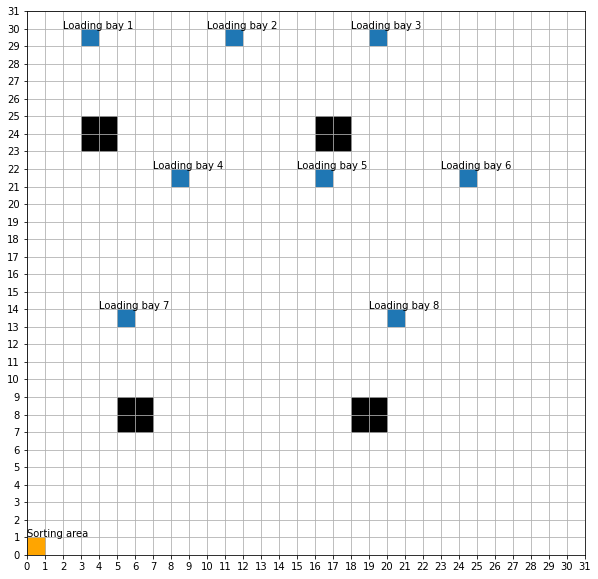

In [ ]:
# field 시각화
simulation.show_field()

In [ ]:
# 스케쥴링 수행
simulation.schedule()

Scheduling Done!


In [ ]:
# 결과 확인
simulation.show_result()

********** transportation #1 **********
운반 전 무게: [300, 500, 200, 100, 200, 400, 100, 300]
운반 전 남은시간: [160, 240, 250, 170, 330, 450, 340, 190]
Sorting area부터의 거리: [32, 40, 48, 29, 37, 45, 18, 33]
우선순위: [0, 3, 7, 1, 2, 4, 6, 5]
방문 순서: 0 -> 1
운반 후 무게 [0, 300, 200, 100, 200, 400, 100, 300]
운반 후 남은시간 [80, 160, 170, 90, 250, 370, 260, 110]
이동 거리: 80
누적 이동 거리: 80
***************************************

********** transportation #2 **********
운반 전 무게: [0, 300, 200, 100, 200, 400, 100, 300]
운반 전 남은시간: [80, 160, 170, 90, 250, 370, 260, 110]
Sorting area부터의 거리: [32, 40, 48, 29, 37, 45, 18, 33]
우선순위: [3, 7, 1, 2, 4, 6, 5]
방문 순서: 3 -> 1 -> 2
운반 후 무게 [0, 0, 100, 0, 200, 400, 100, 300]
운반 후 남은시간 [-16, 64, 74, -6, 154, 274, 164, 14]
이동 거리: 96
누적 이동 거리: 176
***************************************

********** transportation #3 **********
운반 전 무게: [0, 0, 100, 0, 200, 400, 100, 300]
운반 전 남은시간: [-16, 64, 74, -6, 154, 274, 164, 14]
Sorting area부터의 거리: [32, 40, 48, 29, 37, 45, 18, 33]
우선순위: [7, 2, 4, 6, 5]
